# Training a Machine Learning Classifier for HP-PPI Prediction Task

Classifier: Logistic Regression
- performs well with sparse variables
- needs no preprocessing
- relatively fast

In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, f1_score, average_precision_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall

from IPython.display import display, Markdown

# Suppress warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ChangedBehaviorWarning

warnings.simplefilter('ignore', category=(UndefinedMetricWarning,
                                          ChangedBehaviorWarning,
                                          RuntimeWarning))

In [2]:
# Set up directories
SEED = 149028763
parent_dir = os.path.dirname(os.getcwd())

dir_in = os.path.join(parent_dir, 'data', 'features')
dir_out = os.path.join(parent_dir, 'data', 'results')

In [3]:
# Function for combining datasets
def get_dataset(pathogens):
    '''Combine features and labels of different pathogen datasets'''
    
    X = []
    y = []
    
    # Iterate through datasets
    for pathogen in pathogens:
        f_in = os.path.join(dir_in, '%s_features.pkl' % pathogen)
        X_, y_ = joblib.load(f_in)
        X.append(X_)
        y.append(y_)
    
    # Combine features (X) and labels (y)
    X = sparse.vstack(X)
    y = np.concatenate(y)
    
    return X, y

In [4]:
# Load all datasets
pathogens = ['Bacan', 'Yerpe', 'Fratu']
X, y = get_dataset(pathogens)
print('Loaded %i samples with %i features' % X.shape)

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify=y,
                                                    random_state=SEED)

Loaded 105822 samples with 4456 features


## Hyperparameter Tuning

Bayesian optimization with `hyperopt`

In [11]:
# Built-in logistic regression tuning with CV
Cs = np.logspace(-2, 2, 20)
clf = LogisticRegressionCV(Cs=Cs, penalty='l2', solver='lbfgs',
                           cv=5, scoring='f1', max_iter=2000,
                           n_jobs=5, random_state=SEED)

_ = clf.fit(X_train, y_train)

# Dump model as pickle
_ = joblib.dump(clf, 'best_model.pkl')

In [12]:
# Examine model parameter
print('Best parameter: C = %.4f' % clf.C_)
print('Test precision score: %.4f' % clf.score(X_test, y_test))

Best parameter: C = 1.2743
Test precision score: 0.7387


              precision    recall  f1-score   support

           0     0.9758    0.9876    0.9816      9829
           1     0.8079    0.6804    0.7387       754

    accuracy                         0.9657     10583
   macro avg     0.8918    0.8340    0.8602     10583
weighted avg     0.9638    0.9657    0.9643     10583



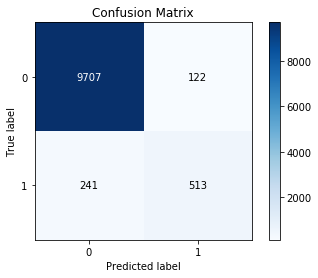

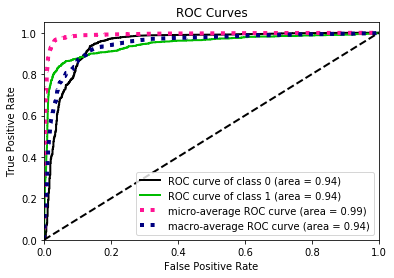

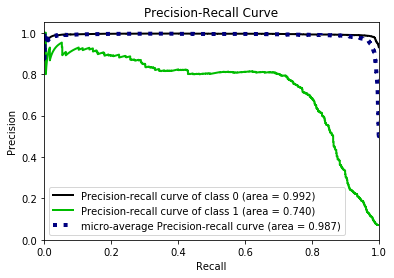

In [17]:
# Evaluate model
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

print(classification_report(y_test, y_pred, digits=4))

# Plot metrics
_ = plot_confusion_matrix(y_test, y_pred)
_ = plot_roc(y_test, y_proba)
_ = plot_precision_recall(y_test, y_proba)
_ = plt.show()

## Evaluate model on partitioned datasets

In [8]:
# Train and test classifier on different datasets
## Partition datasets by pathogen species
%matplotlib inline
i = 0 # track number of tests

for p_test in pathogens:
    p_train = [p for p in pathogens if p != p_test]
    X_train, y_train = get_dataset(p_train)
    
    # Train classifier with validation set
    _ = clf.fit(X_train, y_train)
    print('C = %.6f' % clf.C_)
    
    # Evaluate performance on test set
    X_test, y_test = get_dataset([p_test])
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    
    i += 1
    
    print('Test %i'.center(70) % i)
    print('Test Pathogen: %s\n'.center(70) % p_test)
    print(classification_report(y_test, y_pred, digits=4))
    
    # Plot metrics
    _ = plot_confusion_matrix(y_test, y_pred)
    _ = plot_roc(y_test, y_proba)
    _ = plot_precision_recall(y_test, y_proba)
    _ = plt.show()
    
    display(Markdown('<hr></hr>'))

KeyboardInterrupt: 